**This is a work in progress.** The format is intentionally flat as opposed to modular, to demonstrate the exploratory approach to solving the problem.

## Problem summary:
Recordings from accelerometers strapped to a participant's chest are to be used to determine the activity the participant is performing, using labeled data. The sensors record at 52Hz. 

The data set is not large, and can be opened in memory easily. 

For more information, see: http://archive.ics.uci.edu/ml/datasets/Activity+Recognition+from+Single+Chest-Mounted+Accelerometer#

---
## Approach:



If we imagine this device is going to be used as a wearable, then ideally identification would happen in real time with a few seconds worth of readings. 

For time-series data, particularly  on the data and use the transform as input to the network for training. 

Alternatively, it would be interesting to know whether an LSTM network would be able to quickly learn to compare values to previous ones, and abstract "frequency" from the *raw* data. I will be comparing these two approaches in this experiment.

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import theano
import theano.tensor as T
import lasagne
from sklearn.linear_model import SGDClassifier
import os

In [135]:
# helper functions for describing data

def get_file_names():
    return np.arange(1, 16)


def get_activities():
    
    activities = {
        1: "Working at Computer",
        2: "Standing Up, Walking and Going updown stairs",
        3: "Standing",
        4: "Walking",
        5: "Going UpDown Stairs",
        6: "Walking and Talking with Someone",
        7: "Talking while Standin",        
    }
    return activities

#Load data set for exploration

In [189]:
def load_raw_data():

    data_dir = os.getcwd() + "/data/"
    file_names = get_file_names()    
    
    column_labels = [ "index", "x_accel", "y_accel", "z_accel", "activity"]
    
    # store the data as dataframes in a dictionary,
    # which makes it easier to later separate dataset
    # into training, validation, and testing subsets
    dataset = {}
    for file_name in file_names:
        df = pd.read_csv(data_dir + str(file_name) + ".csv", names = column_labels)
        del df['index'] # useless sequence of numbers in original data
        dataset[file_name] = df
        
    return dataset


# Discover distribution of data per activity and per file

In [190]:
data_lib = load_raw_data()

for file_name, df in data_lib.items():

    print("file #", file_name)
    activity_histogram = df.groupby('activity').size()
    print(activity_histogram)
    
    print("total:", len(df))
    print()

file # 1
activity
0        1
1    33677
2      928
3    11179
4    26860
5     3191
6     2917
7    83748
dtype: int64
total: 162501

file # 2
activity
0      270
1    44150
2     3490
3    23475
4    22175
5     3910
6     7100
7    33431
dtype: int64
total: 138001

file # 3
activity
0        1
1    41675
2     5475
3     4293
4    25900
5     2657
6     1400
7    20940
dtype: int64
total: 102341

file # 4
activity
0        1
1    31540
2     4810
3    21405
4    23300
5     3745
6     1910
7    35490
dtype: int64
total: 122201

file # 5
activity
0        1
1    30980
2     5370
3    13420
4    26750
5     3000
6     2880
7    77600
dtype: int64
total: 160001

file # 6
activity
0      231
1    44040
2     3460
3    23495
4    22040
5     3935
6     6989
7    36711
dtype: int64
total: 140901

file # 7
activity
0        1
1    32750
2     3600
3    10519
4    26770
5     2960
6     2700
7    83701
dtype: int64
total: 163001

file # 8
activity
0      206
1    44040
2     3485
3    24605


# Conclusions about data distribution:
1. Data about activities is distributed  unevenly across files. Some files are 2x as long as others. More importantly, some activities are represented over 100x more than others. Therefore, our sampling method should enforce equal representation of activities in order to prevent our model from being biased towards activities that are simply more frequent. Of course, we do not want to throw out any training data. Sampling method below takes care of this.
2. There is one more distinct activity than expected (8 instead of the 7 described in the problem website). Further investigation shows some rows have 0 in the activity column. In training, we should ignore those rows.

#Visualize sample file 
##(Colored by activities)

In [140]:
example = data_lib[9]

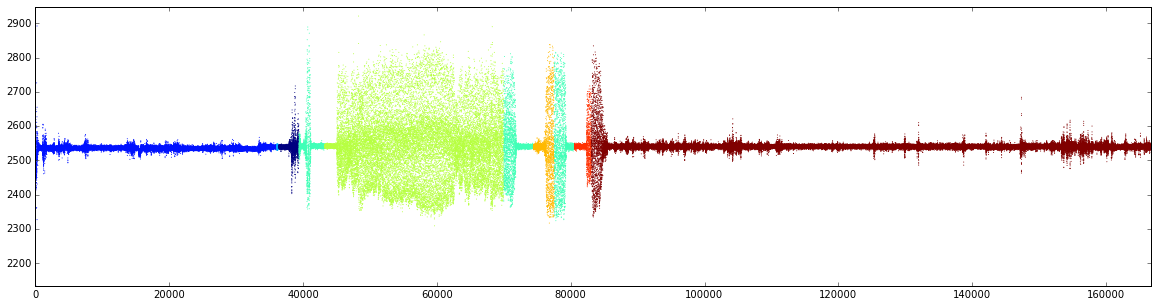

In [141]:
# set plot size and options
fig, ax = plt.subplots(figsize=(20,5))

# center the plot properly
ax.set_ylim(example.y_accel.min(), example.y_accel.max())
ax.set_xlim(0, len(example.index))

# scatter plot with different color for each activity
ax.scatter(example.index, example.y_accel, c=example.activity, edgecolor='', s=1)

# x_accel and z_accel values seem very similar, so they're not included

# Conclusions from sample data:
1. Fourier transforms are almost certainly a good idea.
2. Variance could be a feature for a learning algorithm
2. Removing outliers may be a good experiment to run if time allows for further optimization
3. Data range in the thousands means normalization will be useful in most cases and necessary with neural networks

# Perform fourier transform on activities and plot

In [118]:
# we don't care about the phase (imaginary part of the transform)
# so just get the absolute value: sqrt(a^2 + b^2) where a + bi is the FFT value
def abs_rfft( series ):
    complex_fourier = np.fft.rfft( series )
    return np.absolute(complex_fourier)

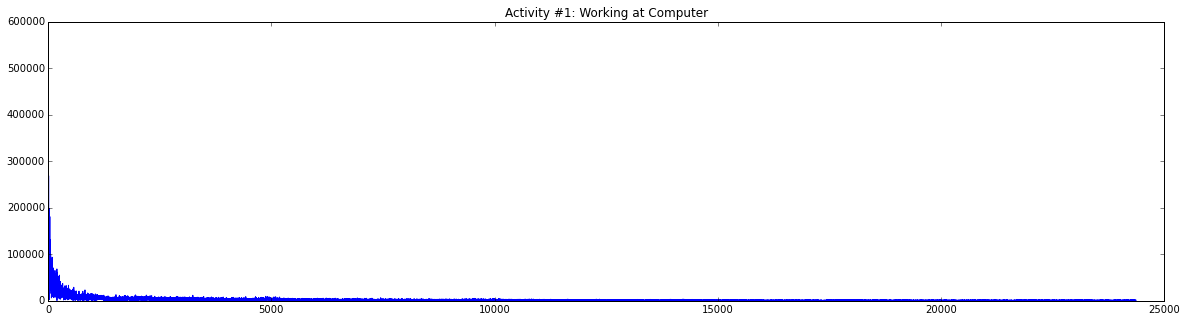

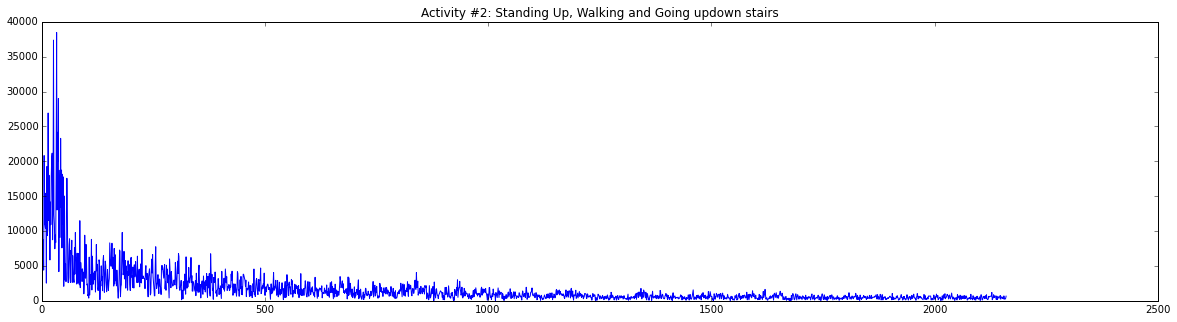

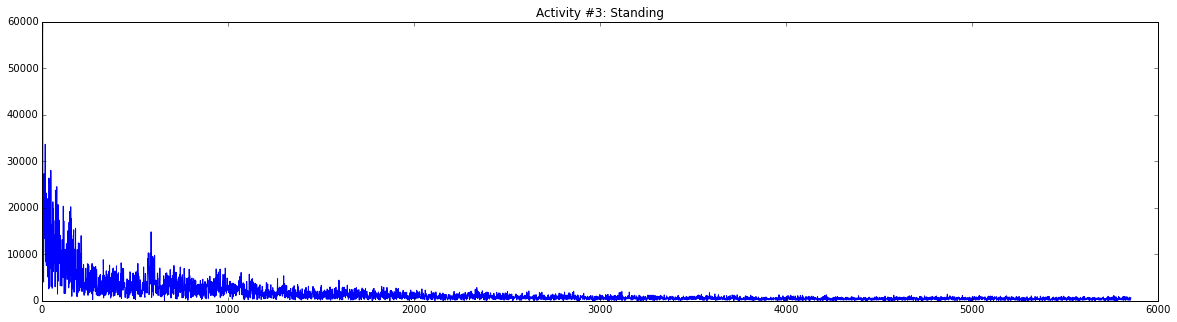

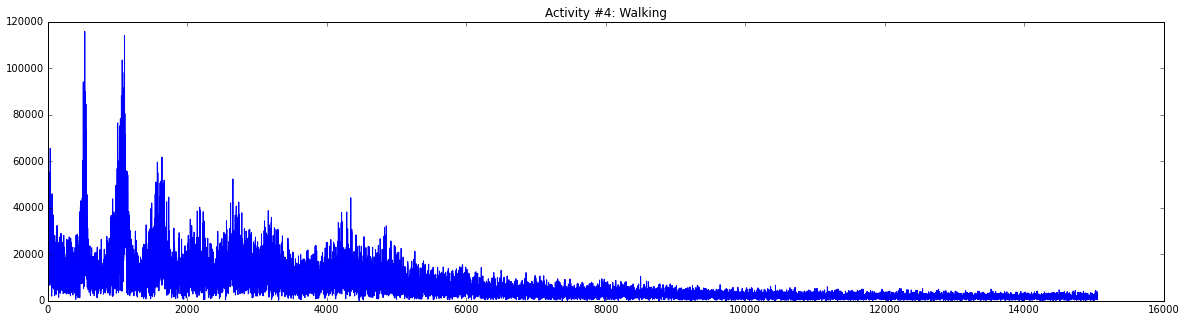

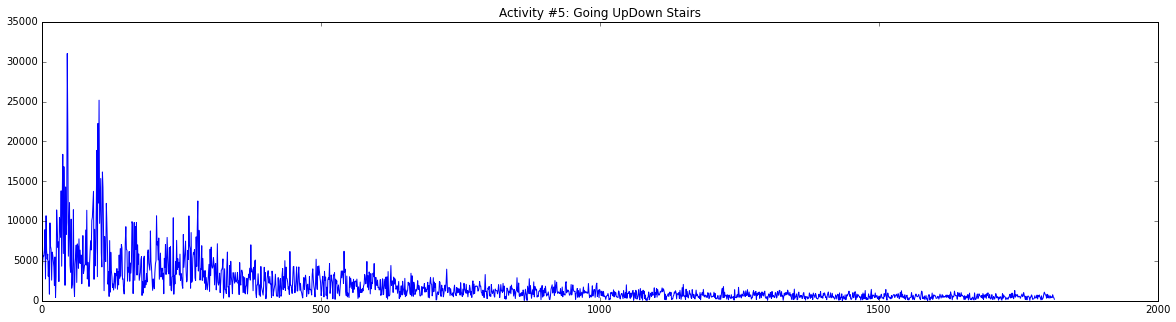

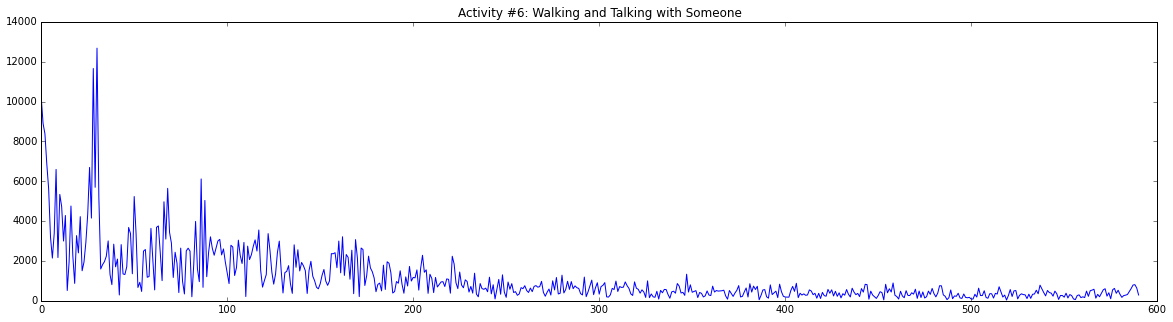

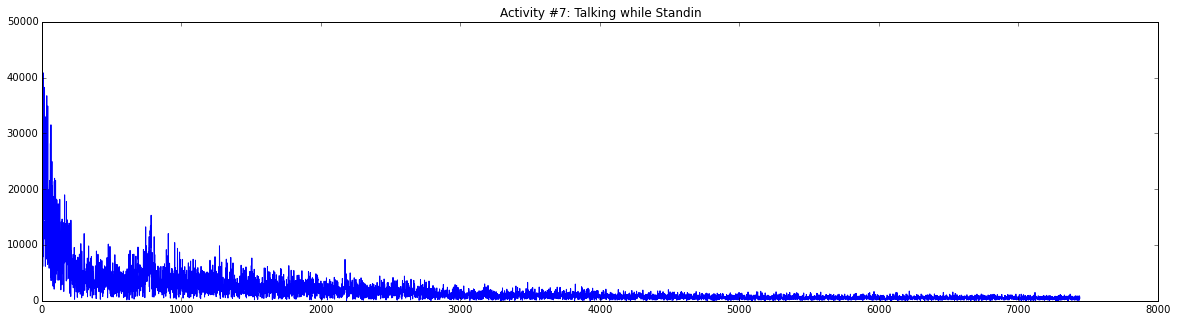

In [136]:
# produce plots for fourier transforms of each activity in sample file
activities = get_activities()
for activity_num, label in activities.items():
    example_filtered = example[example.activity == activity_num]
    ex_fft = abs_rfft( example_filtered.x_accel)
    fig, f_ax = plt.subplots(figsize=(20,5))
    f_ax.set_title(label='Activity #' + str(activity_num) + ': ' + str(label))
    f_ax.plot(ex_fft[10:]) # near-zero frequencies have enormous amplitude (millions). Skipping in plot.

# Notable things about plots of fourier transforms of activities:
0. The top few maximum values could be a useful feature
1. The tail ends may carry little value. Worth experimenting with truncating second half to speed up training / optimizing later.
2. It would be interesting to look at shorter sequences for each activity, and perhaps across files. Frequency ranges should be similar for smaller time-scales.
3. Extreme amplitudes pop up for near-zero frequencies.

#Randomly select training, validation, and test files

In [113]:
# of the 15 files given, select n at random for training and m for validation
def split_dataset(train_size = 10, valid_size = 1):

    filenames = get_file_names()
    
    # raise error if requested sets exceed available num of sets
    if train_size + valid_size >= len(filenames):
        raise ValueError("No room for test files. Total should be less than", len(filenames))
    
    # shuffle file names
    np.random.shuffle(filenames)
    
    train_filenames = filenames[0:train_size]
    valid_filenames = filenames[train_size: train_size+valid_size]
    test_filenames = filenames[train_size+valid_size::]
    
    return train_filenames, valid_filenames, test_filenames

In [134]:
"""
Returns a single sample of contiguous rows from one of the raw data files.
Optionally, you can restrict sampling to subset of files,
and to a particular activity.
The length of the sample defaults to 520, which corresponds to 10 seconds of activity,
but can be set as an argument sample_length.

This functions samples equally from all activities if no activity is defined,
which is ideal for training, because in the raw data, different activities
are represented unequally
"""

def get_sample(allowed_files=get_file_names(), act_num=None, sample_length = 520):
    

    file_name = np.random.choice(allowed_files)
    
    file_data = data_lib[file_name]
    
    # We specify activity in order to 
    # a) avoid sampling rows spanning multiple activities, and
    # b) give equal opportunity to each activity regardless of its relative representation in the dataset
    if act_num is None:
        act_num = np.random.choice(range(1,8))
        
    # filter data to activity specified
    activity_data = file_data[file_data.activity == act_num]
    
    # take a horizontal slice of the activity data of given length
    array_length = len(activity_data)
    
    if array_length <= sample_length:
        snapshot = activity_data
    else:
        start_index = np.random.choice(range(0, array_length - sample_length), 1)
        end_index = start_index + sample_length
        sample = activity_data[start_index:end_index]
    
    sample_inputs = sample[['x_accel', 'y_accel', 'z_accel' ]]
    sample_target = act_num
    
    return sample_inputs, sample_target

In [54]:
def build_sample_set(file_names=None, num_samples=100, sample_length=520, fourier_transform=False):
    sample_set = list()
    sampled = 0
    while sampled < num_samples:
        new_sample = sample(file_names, sample_length=sample_length)
        sample_set.append(new_sample)
        sampled += 1
    
    return sample_set

In [58]:
training_file_names, validation_file_names, test_file_names = split_dataset(10, 2)

train_set = build_sample_set(training_file_names, num_samples=7000)
validation_set = build_sample_set(validation_file_names, num_samples = 100)
test_set = build_sample_set(test_file_names, num_samples = 777)

In [59]:
"""
Let's pickle (save to disk) the generated training, validation, and test sets.
These are expensive to generate on the fly, 
particularly if we normalize or apply Fourier Transforms down the line
"""
train = open('train_set', 'wb')
pickle.dump(train_set, train)

valid = open('validation_set', 'wb')
pickle.dump(validation_set, valid)

test = open('testing_set', 'wb')
pickle.dump(test_set, test)

In [178]:
# Let's explore the 10 second snapshot of a random activity
X, y = get_sample()

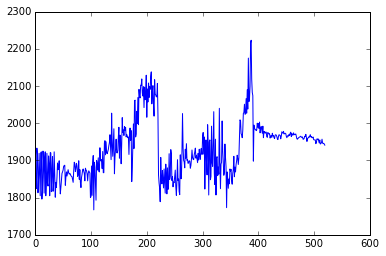

In [179]:
plt.plot(X.x_accel.values)

In [180]:
sample_fourier = abs_rfft(X.x_accel)

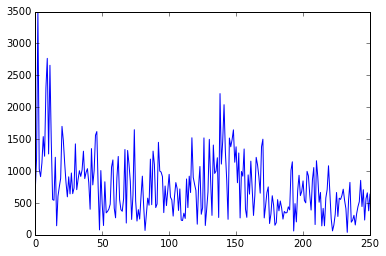

In [184]:
plt.plot(sample_fourier[10::])